# Build an AI Agent to Automate Your Research

## 🎯 Learning Objectives

By the end of this notebook, you will:
- ✅ Understand how AI agents can automate research tasks
- ✅ Learn about vector embeddings and semantic search
- ✅ Build a complete RAG (Retrieval-Augmented Generation) system
- ✅ Master concepts like chunking, embedding, and similarity ranking
- ✅ Explore advanced options and alternative approaches
- ✅ Practice with hands-on exercises

## 📚 What You'll Build

A powerful AI research agent that:
- Takes your research question as input
- Searches the web automatically
- Reads and extracts content from multiple sources
- Finds the most relevant passages using semantic similarity
- Generates a concise summary with sources

## 🧠 Key Concepts You'll Learn

1. **Vector Embeddings**: Converting text into numerical representations
2. **Semantic Search**: Finding meaning, not just keywords
3. **RAG Architecture**: Retrieve → Rank → Generate
4. **Cosine Similarity**: Measuring how similar two pieces of text are
5. **Text Chunking**: Breaking long documents into manageable pieces

## 🛠️ Toolkit

1. **SentenceTransformers**: For creating text embeddings
2. **DuckDuckGo Search**: Free web search (no API key needed)
3. **BeautifulSoup**: For web scraping and HTML parsing
4. **NumPy**: For mathematical operations and similarity calculations

---

## ⚠️ Prerequisites

Before starting, make sure you have installed:

```bash
pip install ddgs requests beautifulsoup4 sentence-transformers numpy matplotlib seaborn pandas
```

**Note**: The first time you run this notebook, SentenceTransformer will download a model (~80MB). This happens automatically but requires an internet connection.


## Step 1: Verify Your Setup

Let's check if all required packages are installed correctly.


In [32]:
# Verify installations
import sys

required_packages = {
    'ddgs': 'ddgs',
    'requests': 'requests',
    'bs4': 'beautifulsoup4',
    'sentence_transformers': 'sentence-transformers',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'pandas': 'pandas'
}

missing_packages = []
for module, package in required_packages.items():
    try:
        __import__(module)
        print(f"✅ {package} is installed")
    except ImportError:
        print(f"❌ {package} is NOT installed")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️  Please install missing packages:")
    print(f"pip install {' '.join(missing_packages)}")
else:
    print("\n🎉 All packages are installed! You're ready to go!")


✅ ddgs is installed
✅ requests is installed
✅ beautifulsoup4 is installed
✅ sentence-transformers is installed
✅ numpy is installed
✅ matplotlib is installed
✅ seaborn is installed
✅ pandas is installed

🎉 All packages are installed! You're ready to go!


## Step 2: Understanding the Problem

### Why Traditional Search Isn't Enough

When you search Google for "What causes climate change?", you get:
- Pages that mention "climate change" and "causes"
- But they might not actually explain the causes
- You have to read through many pages to find the answer

### What Our Agent Does Differently

Our agent uses **semantic understanding**:
- It understands that "climate change causes" and "reasons for global warming" are similar
- It finds passages that **mean** the same thing, not just contain the same words
- It ranks results by how relevant they are to your question
- It gives you a summary with sources

### The RAG Pipeline

**R**etrieve → **A**ugment → **G**enerate

1. **Retrieve**: Search web, fetch pages, extract text
2. **Augment**: Convert to embeddings, find similar passages
3. **Generate**: Create summary from top passages


## Step 3: Import Libraries and Configure Parameters

Let's start by importing all the libraries we need and setting up our configuration.


In [33]:
# Standard library imports
import re
import urllib.parse
import time
from typing import List, Dict, Optional

# Third-party imports
from ddgs import DDGS  # DuckDuckGo Search (free, no API key needed)
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
import numpy as np

# Optional: For visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


### Configuration Parameters

These are the "knobs" you can adjust to control your agent's behavior:

- **SEARCH_RESULTS**: How many web pages to search
- **PASSAGES_PER_PAGE**: How many text chunks to extract from each page
- **EMBEDDING_MODEL**: Which model to use for creating embeddings
- **TOP_PASSAGES**: How many most relevant passages to use
- **SUMMARY_SENTENCES**: How many sentences in the final summary
- **TIMEOUT**: How long to wait for a webpage to load


In [34]:
# Configuration - Feel free to experiment with these values!
SEARCH_RESULTS = 6        # How many URLs to check (more = slower but potentially better results)
PASSAGES_PER_PAGE = 4     # How many passages to pull from each URL
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # Fast, high-quality model
TOP_PASSAGES = 5          # How many relevant passages to use for the summary
SUMMARY_SENTENCES = 3     # How many sentences in the final summary
TIMEOUT = 8               # How long to wait for a webpage to load (seconds)

# Alternative embedding models you can try:
# "sentence-transformers/all-mpnet-base-v2"  # Slower but higher quality
# "sentence-transformers/paraphrase-MiniLM-L6-v2"  # Good for paraphrasing
# "sentence-transformers/all-MiniLM-L12-v2"  # Larger, better quality

print("Configuration loaded:")
print(f"  Search Results: {SEARCH_RESULTS}")
print(f"  Passages per Page: {PASSAGES_PER_PAGE}")
print(f"  Embedding Model: {EMBEDDING_MODEL}")
print(f"  Top Passages: {TOP_PASSAGES}")
print(f"  Summary Sentences: {SUMMARY_SENTENCES}")
print(f"  Timeout: {TIMEOUT}s")


Configuration loaded:
  Search Results: 6
  Passages per Page: 4
  Embedding Model: sentence-transformers/all-MiniLM-L6-v2
  Top Passages: 5
  Summary Sentences: 3
  Timeout: 8s


## Step 4: Web Search Function

### Understanding DuckDuckGo Search

DuckDuckGo provides free web search without requiring an API key. However, sometimes it returns redirect URLs that we need to unwrap to get the actual destination.

**Key Concept**: URL unwrapping extracts the real destination from redirect links.


In [35]:
def unwrap_ddg(url: str) -> str:
    """
    If DuckDuckGo returns a redirect wrapper, extract the real URL.
    
    Sometimes DuckDuckGo wraps URLs like:
    https://duckduckgo.com/l/?uddg=https://example.com
    
    This function extracts the actual URL.
    
    Args:
        url: The URL that might be wrapped
        
    Returns:
        The unwrapped URL or the original URL if not wrapped
    """
    try:
        parsed = urllib.parse.urlparse(url)
        if "duckduckgo.com" in parsed.netloc:
            qs = urllib.parse.parse_qs(parsed.query)
            uddg = qs.get("uddg")
            if uddg:
                return urllib.parse.unquote(uddg[0])
    except Exception:
        pass
    return url


def search_web(query: str, max_results: int = SEARCH_RESULTS) -> List[str]:
    """
    Search the web using DuckDuckGo and return a list of URLs.
    
    This function:
    1. Uses DuckDuckGo to search for the query
    2. Extracts URLs from search results
    3. Unwraps any redirect URLs
    4. Returns a list of clean URLs
    
    Args:
        query: The search query (your research question)
        max_results: Maximum number of URLs to return
        
    Returns:
        List of URLs from search results
    """
    urls = []
    try:
        with DDGS() as ddgs:
            for r in ddgs.text(query, max_results=max_results):
                url = r.get("href") or r.get("url")
                if not url:
                    continue
                url = unwrap_ddg(url)  # Clean up DDG redirect links
                urls.append(url)
    except Exception as e:
        print(f"⚠️  Search error: {e}")
    return urls


# Test the search function
print("Testing web search...")
test_urls = search_web("Python programming", max_results=3)
print(f"Found {len(test_urls)} URLs:")
for i, url in enumerate(test_urls, 1):
    print(f"  {i}. {url[:80]}...")


Testing web search...
Found 3 URLs:
  1. https://en.wikipedia.org/wiki/Python_(programming_language)...
  2. https://grokipedia.com/page/Python_(programming_language)...
  3. https://www.python.org/...


In [36]:
def fetch_text(url: str, timeout: int = TIMEOUT) -> str:
    """
    Fetch and clean text content from a URL.
    
    This function:
    1. Downloads the webpage
    2. Parses the HTML
    3. Removes unwanted elements (scripts, styles, navigation, etc.)
    4. Extracts paragraph text
    5. Cleans up whitespace
    
    Args:
        url: The URL to fetch
        timeout: How long to wait for the page to load
        
    Returns:
        Clean text content from the page, or empty string if failed
    """
    headers = {"User-Agent": "Mozilla/5.0 (research-agent)"}
    try:
        r = requests.get(url, timeout=timeout, headers=headers, allow_redirects=True)
        if r.status_code != 200:
            return ""
        
        ct = r.headers.get("content-type", "")
        if "html" not in ct.lower():  # Skip non-HTML content (PDFs, images, etc.)
            return ""
        
        soup = BeautifulSoup(r.text, "html.parser")
        
        # Remove all annoying tags that don't contain useful content
        for tag in soup(["script", "style", "noscript", "header", "footer", 
                        "svg", "iframe", "nav", "aside", "form", "button"]):
            tag.extract()
        
        # Get all paragraph text (most web pages use <p> tags for content)
        paragraphs = [p.get_text(" ", strip=True) for p in soup.find_all("p")]
        text = " ".join([p for p in paragraphs if p])
        
        if text.strip():
            # Clean up whitespace (multiple spaces, newlines, etc.)
            return re.sub(r"\s+", " ", text).strip()
        
        # --- Fallback logic if <p> tags fail ---
        # Try to get meta description or title
        meta = soup.find("meta", attrs={"name": "description"}) or \
               soup.find("meta", attrs={"property": "og:description"})
        if meta and meta.get("content"):
            return meta["content"].strip()
        if soup.title and soup.title.string:
            return soup.title.string.strip()
            
    except requests.exceptions.Timeout:
        print(f"⏱️  Timeout fetching {url}")
    except Exception as e:
        print(f"⚠️  Error fetching {url}: {str(e)[:50]}")
    return ""


# Test fetching a page
print("Testing page fetching...")
if test_urls:
    test_text = fetch_text(test_urls[0])
    print(f"Fetched {len(test_text)} characters from first URL")
    print(f"Preview: {test_text[:200]}...")
else:
    print("No URLs to test")


Testing page fetching...
Fetched 22269 characters from first URL
Preview: Python is a high-level , general-purpose programming language . Its design philosophy emphasizes code readability with the use of significant indentation . [ 34 ] Python is dynamically type-checked an...


In [37]:
def chunk_passages(text: str, max_words: int = 120) -> List[str]:
    """
    Split long text into smaller passages (chunks).
    
    This function breaks text into chunks of approximately max_words.
    Each chunk can be embedded separately for more precise matching.
    
    Args:
        text: The text to chunk
        max_words: Maximum words per chunk
        
    Returns:
        List of text chunks
    """
    words = text.split()
    if not words:
        return []
    
    chunks = []
    i = 0
    while i < len(words):
        chunk = words[i : i + max_words]
        chunks.append(" ".join(chunk))
        i += max_words
    
    return chunks


def split_sentences(text: str) -> List[str]:
    """
    A simple sentence splitter.
    
    Splits text on sentence boundaries (., !, ?).
    
    Args:
        text: Text to split
        
    Returns:
        List of sentences
    """
    parts = re.split(r'(?<=[.!?])\s+', text)
    return [p.strip() for p in parts if p.strip()]


# Test chunking
test_long_text = """
Artificial intelligence is transforming the way we work and live. 
Machine learning algorithms can now recognize patterns in data that humans might miss. 
Deep learning, a subset of machine learning, uses neural networks to process information. 
These networks are inspired by the human brain's structure. 
Natural language processing allows computers to understand and generate human language. 
Computer vision enables machines to interpret and understand visual information. 
AI applications range from healthcare to finance to transportation. 
The future of AI holds great promise but also raises important ethical questions.
""" * 3  # Repeat to make it longer

chunks = chunk_passages(test_long_text, max_words=30)
print(f"Original text: {len(test_long_text.split())} words")
print(f"Split into {len(chunks)} chunks")
print("\nFirst 3 chunks:")
for i, chunk in enumerate(chunks[:3], 1):
    print(f"\nChunk {i} ({len(chunk.split())} words):")
    print(f"  {chunk[:100]}...")


Original text: 264 words
Split into 9 chunks

First 3 chunks:

Chunk 1 (30 words):
  Artificial intelligence is transforming the way we work and live. Machine learning algorithms can no...

Chunk 2 (30 words):
  uses neural networks to process information. These networks are inspired by the human brain's struct...

Chunk 3 (30 words):
  to interpret and understand visual information. AI applications range from healthcare to finance to ...


## Step 7: Understanding Embeddings and Similarity

### What Are Embeddings?

**Embeddings** are numerical representations of text that capture meaning.

Think of it like this:
- "car" and "automobile" → similar numbers (close in meaning)
- "car" and "banana" → very different numbers (different meanings)

### Cosine Similarity

**Cosine similarity** measures how similar two vectors are:
- **1.0** = identical meaning
- **0.0** = completely unrelated
- **-1.0** = opposite meaning

Let's visualize this concept!


Loading embedding model (this may take a moment on first run)...
✅ Model loaded!

Query: 'What causes climate change?'

Similarity scores:
  0.777 - 'What are the reasons for global warming?'
  0.532 - 'How does the greenhouse effect work?'
  0.342 - 'What is the weather like today?'
  0.002 - 'I love eating pizza for dinner.'


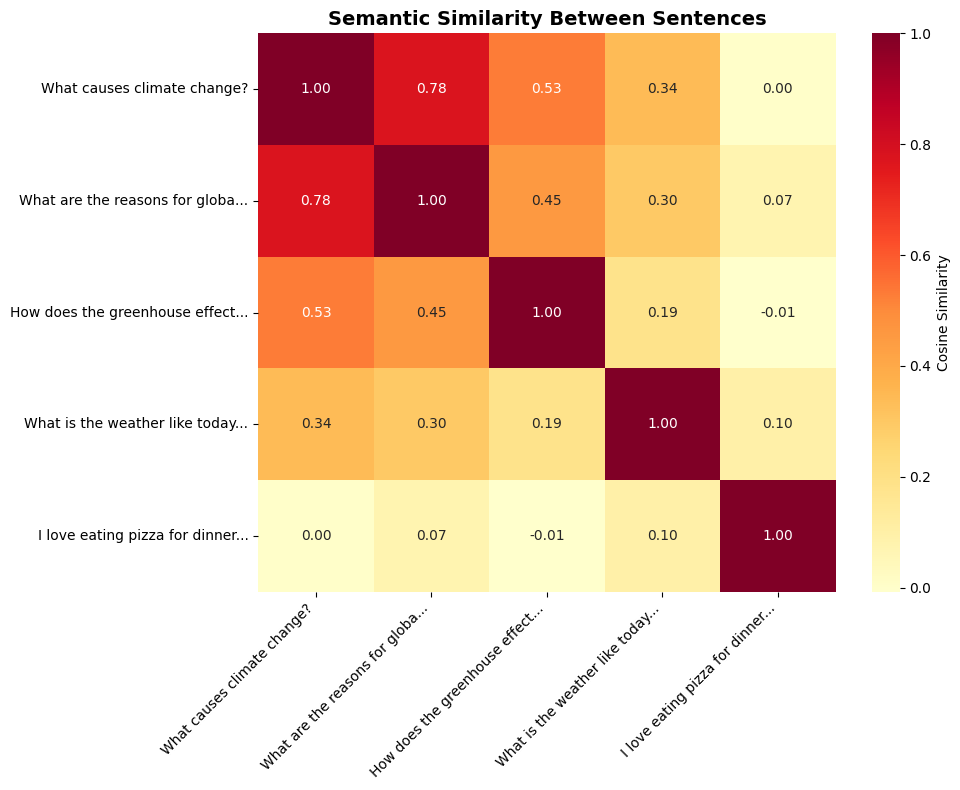


💡 Notice how similar questions have high similarity scores!
   This is how our agent finds relevant passages.


In [38]:
# Let's create a simple demonstration of embeddings and similarity
print("Loading embedding model (this may take a moment on first run)...")
demo_model = SentenceTransformer(EMBEDDING_MODEL)
print("✅ Model loaded!")

# Test sentences with different levels of similarity
test_sentences = [
    "What causes climate change?",
    "What are the reasons for global warming?",
    "How does the greenhouse effect work?",
    "What is the weather like today?",
    "I love eating pizza for dinner."
]

# Convert to embeddings
embeddings = demo_model.encode(test_sentences, convert_to_numpy=True)

# Calculate cosine similarity
def cosine_similarity(a, b):
    """Calculate cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)

# Compare the first sentence (query) with all others
query = test_sentences[0]
query_embedding = embeddings[0]

print(f"\nQuery: '{query}'\n")
print("Similarity scores:")
for i, sentence in enumerate(test_sentences[1:], 1):
    similarity = cosine_similarity(query_embedding, embeddings[i])
    print(f"  {similarity:.3f} - '{sentence}'")

# Visualize similarity matrix
similarity_matrix = np.zeros((len(test_sentences), len(test_sentences)))
for i in range(len(test_sentences)):
    for j in range(len(test_sentences)):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, 
            xticklabels=[s[:30] + "..." if len(s) > 30 else s for s in test_sentences],
            yticklabels=[s[:30] + "..." if len(s) > 30 else s for s in test_sentences],
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Semantic Similarity Between Sentences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Notice how similar questions have high similarity scores!")
print("   This is how our agent finds relevant passages.")


## Step 8: Building the Research Agent

Now let's put it all together! This is the main class that orchestrates the entire research process.


In [39]:
class ShortResearchAgent:
    """
    An AI agent that automates research by:
    1. Searching the web for relevant pages
    2. Extracting and chunking content
    3. Finding semantically similar passages
    4. Generating a summary
    """
    
    def __init__(self, embed_model: str = EMBEDDING_MODEL):
        """
        Initialize the research agent.
        
        Args:
            embed_model: The SentenceTransformer model to use
        """
        print(f"Loading embedder: {embed_model}...")
        print("(This downloads the model on first run - may take a minute)")
        self.embedder = SentenceTransformer(embed_model)
        print("✅ Embedder loaded!")
    
    def cosine_similarity(self, a: np.ndarray, b: np.ndarray) -> float:
        """
        Calculate cosine similarity between two vectors.
        
        Cosine similarity ranges from -1 to 1:
        - 1.0: Identical meaning
        - 0.0: Unrelated
        - -1.0: Opposite meaning
        """
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)
    
    def run(self, query: str, verbose: bool = True) -> Dict:
        """
        Run the research agent on a query.
        
        The process:
        1. Search: Find relevant web pages
        2. Fetch & Chunk: Download and break into passages
        3. Embed: Convert text to vectors
        4. Rank: Find most similar passages
        5. Summarize: Extract key sentences
        
        Args:
            query: Your research question
            verbose: Whether to print progress updates
            
        Returns:
            Dictionary with:
            - query: The original query
            - passages: Top relevant passages with scores
            - summary: Generated summary
            - time: Time taken in seconds
            - stats: Additional statistics
        """
        start = time.time()
        
        if verbose:
            print(f"\n🔍 Research Query: '{query}'")
            print("=" * 60)
        
        # Step 1: Search the web
        if verbose:
            print("Step 1: Searching the web...")
        urls = search_web(query, max_results=SEARCH_RESULTS)
        if verbose:
            print(f"   Found {len(urls)} URLs")
        
        # Step 2: Fetch and chunk content
        if verbose:
            print("Step 2: Fetching and chunking content...")
        docs = []
        successful_fetches = 0
        for u in urls:
            txt = fetch_text(u)
            if not txt:
                continue
            successful_fetches += 1
            chunks = chunk_passages(txt, max_words=120)
            for c in chunks[:PASSAGES_PER_PAGE]:
                docs.append({"url": u, "passage": c})
        
        if verbose:
            print(f"   Fetched content from {successful_fetches}/{len(urls)} URLs")
            print(f"   Created {len(docs)} passages")
        
        if not docs:
            if verbose:
                print("⚠️  No documents fetched.")
            return {
                "query": query,
                "passages": [],
                "summary": "No content could be fetched from the web.",
                "time": time.time() - start,
                "stats": {"urls_found": len(urls), "passages_created": 0}
            }
        
        # Step 3: Embed (Convert text to vectors)
        if verbose:
            print("Step 3: Creating embeddings...")
        texts = [d["passage"] for d in docs]
        emb_texts = self.embedder.encode(texts, convert_to_numpy=True, show_progress_bar=False)
        q_emb = self.embedder.encode([query], convert_to_numpy=True)[0]
        if verbose:
            print(f"   Created embeddings for {len(texts)} passages")
        
        # Step 4: Rank (Find similarity)
        if verbose:
            print("Step 4: Ranking passages by relevance...")
        sims = [self.cosine_similarity(e, q_emb) for e in emb_texts]
        top_idx = np.argsort(sims)[::-1][:TOP_PASSAGES]
        top_passages = [
            {
                "url": docs[i]["url"],
                "passage": docs[i]["passage"],
                "score": float(sims[i])
            }
            for i in top_idx
        ]
        if verbose:
            print(f"   Selected top {len(top_passages)} passages")
        
        # Step 5: Summarize (Extractive)
        if verbose:
            print("Step 5: Generating summary...")
        sentences = []
        for tp in top_passages:
            for s in split_sentences(tp["passage"]):
                sentences.append({"sent": s, "url": tp["url"]})
        
        if not sentences:
            summary = "No summary could be generated."
        else:
            sent_texts = [s["sent"] for s in sentences]
            sent_embs = self.embedder.encode(sent_texts, convert_to_numpy=True, show_progress_bar=False)
            sent_sims = [self.cosine_similarity(e, q_emb) for e in sent_embs]
            
            top_sent_idx = np.argsort(sent_sims)[::-1][:SUMMARY_SENTENCES]
            chosen = [sentences[idx] for idx in top_sent_idx]
            
            # De-duplicate and format
            seen = set()
            lines = []
            for s in chosen:
                key = s["sent"].lower()[:80]  # Check first 80 chars for duplication
                if key in seen:
                    continue
                seen.add(key)
                lines.append(f"{s['sent']} (Source: {s['url']})")
            summary = " ".join(lines)
        
        elapsed = time.time() - start
        
        if verbose:
            print(f"\n✅ Research complete in {elapsed:.1f} seconds!")
            print("=" * 60)
        
        return {
            "query": query,
            "passages": top_passages,
            "summary": summary,
            "time": elapsed,
            "stats": {
                "urls_found": len(urls),
                "urls_fetched": successful_fetches,
                "passages_created": len(docs),
                "top_passages": len(top_passages)
            }
        }


print("✅ ResearchAgent class defined!")


✅ ResearchAgent class defined!


In [40]:
# Initialize the agent (this loads the embedding model)
agent = ShortResearchAgent()

# Your research question
query = "What causes urban heat islands and how can cities reduce them?"

# Run the research
results = agent.run(query)


Loading embedder: sentence-transformers/all-MiniLM-L6-v2...
(This downloads the model on first run - may take a minute)
✅ Embedder loaded!

🔍 Research Query: 'What causes urban heat islands and how can cities reduce them?'
Step 1: Searching the web...
   Found 6 URLs
Step 2: Fetching and chunking content...
   Fetched content from 5/6 URLs
   Created 18 passages
Step 3: Creating embeddings...
   Created embeddings for 18 passages
Step 4: Ranking passages by relevance...
   Selected top 5 passages
Step 5: Generating summary...

✅ Research complete in 4.9 seconds!


### Display Results

Let's see what the agent found!


In [41]:
def display_results(results: Dict):
    """Pretty print the research results."""
    print("\n" + "="*70)
    print("📊 RESEARCH RESULTS")
    print("="*70)
    print(f"\n🔍 Query: {results['query']}\n")
    
    print(f"📈 Statistics:")
    stats = results['stats']
    print(f"   URLs found: {stats['urls_found']}")
    print(f"   URLs successfully fetched: {stats['urls_fetched']}")
    print(f"   Passages created: {stats['passages_created']}")
    print(f"   Top passages selected: {stats['top_passages']}")
    print(f"   Time taken: {results['time']:.2f} seconds\n")
    
    print("🏆 Top Relevant Passages:")
    print("-" * 70)
    for i, p in enumerate(results['passages'], 1):
        print(f"\n{i}. Score: {p['score']:.3f}")
        print(f"   Source: {p['url']}")
        print(f"   Passage: {p['passage'][:300]}...")
    
    print("\n" + "-" * 70)
    print("📝 Summary:")
    print("-" * 70)
    print(results['summary'])
    print("="*70)


# Display the results
display_results(results)



📊 RESEARCH RESULTS

🔍 Query: What causes urban heat islands and how can cities reduce them?

📈 Statistics:
   URLs found: 6
   URLs successfully fetched: 5
   Passages created: 18
   Top passages selected: 5
   Time taken: 4.87 seconds

🏆 Top Relevant Passages:
----------------------------------------------------------------------

1. Score: 0.830
   Source: https://en.wikipedia.org/wiki/Urban_heat_island
   Passage: where the city is located. [ 7 ] The impact in a city can significantly change based on its local environment. Heat can be reduced by tree cover and green space, which act as sources of shade and promote evaporative cooling. [ 8 ] Other options include green roofs , passive daytime radiative cooling...

2. Score: 0.819
   Source: https://www.rff.org/publications/explainers/urban-heat-islands-101/
   Passage: This explainer details how heat islands increase temperatures, how different communities are impacted by high urban temperatures, and what can be done to mitigate the

## Step 10: Visualizing Similarity Scores

Let's create a visualization to see how the similarity scores are distributed.


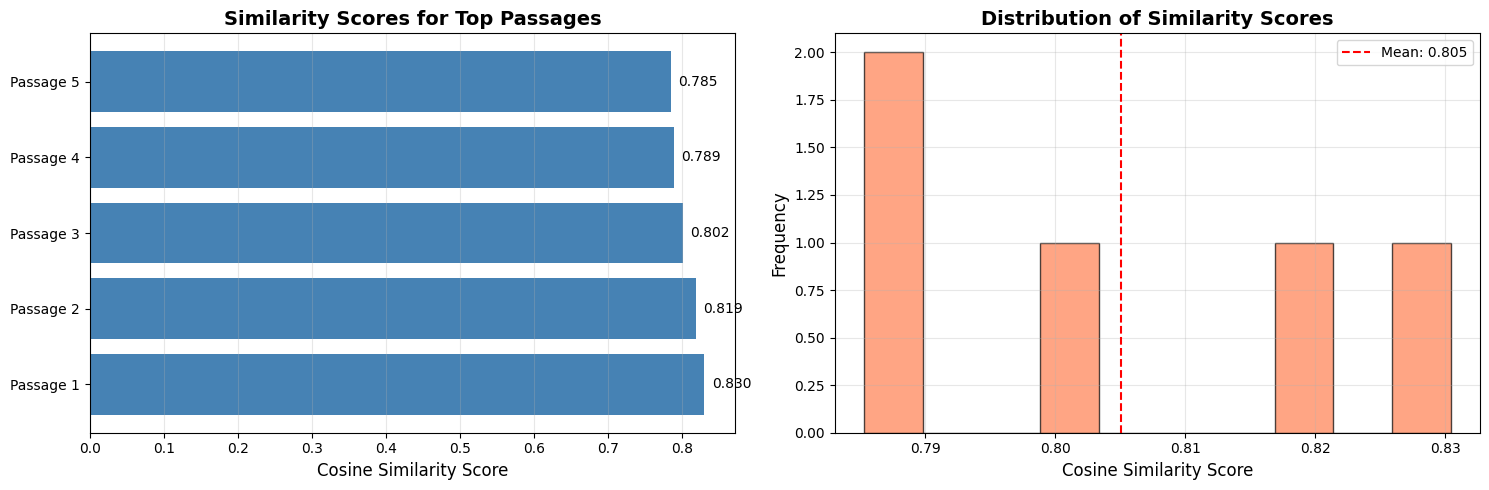


📊 Score Statistics:
   Mean: 0.805
   Median: 0.802
   Min: 0.785
   Max: 0.830


In [42]:
# Visualize similarity scores
if results['passages']:
    scores = [p['score'] for p in results['passages']]
    passage_previews = [p['passage'][:50] + "..." for p in results['passages']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart of scores
    ax1.barh(range(len(scores)), scores, color='steelblue')
    ax1.set_yticks(range(len(scores)))
    ax1.set_yticklabels([f"Passage {i+1}" for i in range(len(scores))])
    ax1.set_xlabel('Cosine Similarity Score', fontsize=12)
    ax1.set_title('Similarity Scores for Top Passages', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, score in enumerate(scores):
        ax1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10)
    
    # Distribution plot
    ax2.hist(scores, bins=10, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Cosine Similarity Score', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Similarity Scores', fontsize=14, fontweight='bold')
    ax2.axvline(np.mean(scores), color='red', linestyle='--', 
                label=f'Mean: {np.mean(scores):.3f}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Score Statistics:")
    print(f"   Mean: {np.mean(scores):.3f}")
    print(f"   Median: {np.median(scores):.3f}")
    print(f"   Min: {np.min(scores):.3f}")
    print(f"   Max: {np.max(scores):.3f}")
else:
    print("No passages to visualize.")


## Step 11: Testing with Different Queries

Let's try the agent with different types of questions to see how it performs.


In [43]:
# Test queries covering different topics
test_queries = [
    "How does machine learning work?",
    "What are the health benefits of exercise?",
    "Explain quantum computing in simple terms"
]

# Run all test queries
all_results = []
for query in test_queries:
    print(f"\n{'='*70}")
    print(f"Testing: {query}")
    print('='*70)
    result = agent.run(query, verbose=False)
    all_results.append(result)
    print(f"✅ Completed in {result['time']:.1f}s")
    print(f"   Found {result['stats']['passages_created']} passages")
    print(f"   Top score: {max([p['score'] for p in result['passages']]):.3f}" if result['passages'] else "   No passages found")



Testing: How does machine learning work?
✅ Completed in 5.8s
   Found 17 passages
   Top score: 0.704

Testing: What are the health benefits of exercise?
✅ Completed in 6.1s
   Found 19 passages
   Top score: 0.682

Testing: Explain quantum computing in simple terms
⏱️  Timeout fetching https://azure.microsoft.com/en-us/resources/cloud-computing-dictionary/what-is-quantum-computing
✅ Completed in 13.0s
   Found 16 passages
   Top score: 0.667


## Step 12: Advanced Features and Customization

### Feature 1: Adjustable Parameters

You can customize the agent's behavior by changing the configuration parameters.


In [44]:
# Example: More thorough research (slower but potentially better)
class AdvancedResearchAgent(ShortResearchAgent):
    """
    Extended agent with more configuration options.
    """
    
    def __init__(self, 
                 embed_model: str = EMBEDDING_MODEL,
                 search_results: int = 10,
                 passages_per_page: int = 6,
                 top_passages: int = 8,
                 summary_sentences: int = 5,
                 chunk_size: int = 150):
        """
        Initialize with custom parameters.
        
        Args:
            embed_model: Embedding model to use
            search_results: Number of URLs to search
            passages_per_page: Passages to extract per URL
            top_passages: Number of top passages to use
            summary_sentences: Sentences in summary
            chunk_size: Words per chunk
        """
        super().__init__(embed_model)
        self.search_results = search_results
        self.passages_per_page = passages_per_page
        self.top_passages = top_passages
        self.summary_sentences = summary_sentences
        self.chunk_size = chunk_size
    
    def run(self, query: str, verbose: bool = True) -> Dict:
        """Run with custom parameters."""
        # Temporarily override global settings
        global SEARCH_RESULTS, PASSAGES_PER_PAGE, TOP_PASSAGES, SUMMARY_SENTENCES
        
        old_search = SEARCH_RESULTS
        old_passages = PASSAGES_PER_PAGE
        old_top = TOP_PASSAGES
        old_summary = SUMMARY_SENTENCES
        
        SEARCH_RESULTS = self.search_results
        PASSAGES_PER_PAGE = self.passages_per_page
        TOP_PASSAGES = self.top_passages
        SUMMARY_SENTENCES = self.summary_sentences
        
        # Use custom chunk size
        def custom_chunk(text, max_words=self.chunk_size):
            return chunk_passages(text, max_words=max_words)
        
        # Store original function
        original_chunk = chunk_passages
        import __main__
        __main__.chunk_passages = custom_chunk
        
        try:
            result = super().run(query, verbose)
        finally:
            # Restore original settings
            SEARCH_RESULTS = old_search
            PASSAGES_PER_PAGE = old_passages
            TOP_PASSAGES = old_top
            SUMMARY_SENTENCES = old_summary
            __main__.chunk_passages = original_chunk
        
        return result


print("✅ AdvancedResearchAgent class defined!")
print("\nYou can now create an agent with custom settings:")
print("  agent = AdvancedResearchAgent(")
print("      search_results=10,")
print("      passages_per_page=6,")
print("      top_passages=8,")
print("      summary_sentences=5")
print("  )")


✅ AdvancedResearchAgent class defined!

You can now create an agent with custom settings:
  agent = AdvancedResearchAgent(
      search_results=10,
      passages_per_page=6,
      top_passages=8,
      summary_sentences=5
  )


### Feature 2: Alternative Embedding Models

Different models have different trade-offs. Let's compare them!


In [45]:
# Compare different embedding models
def compare_models(query: str, models: List[str]):
    """
    Compare different embedding models on the same query.
    
    This helps you understand:
    - Speed differences
    - Quality differences
    - Which model works best for your use case
    """
    results = {}
    
    for model_name in models:
        print(f"\n{'='*60}")
        print(f"Testing model: {model_name}")
        print('='*60)
        
        try:
            start = time.time()
            agent = ShortResearchAgent(embed_model=model_name)
            result = agent.run(query, verbose=False)
            elapsed = time.time() - start
            
            results[model_name] = {
                'time': elapsed,
                'top_score': max([p['score'] for p in result['passages']]) if result['passages'] else 0,
                'passages': len(result['passages']),
                'summary_length': len(result['summary'])
            }
            print(f"✅ Completed in {elapsed:.1f}s")
        except Exception as e:
            print(f"❌ Error: {e}")
            results[model_name] = None
    
    return results


# Uncomment to compare models (this takes a while!)
alternative_models = [
    "sentence-transformers/all-MiniLM-L6-v2",  # Fast, default
    "sentence-transformers/all-MiniLM-L12-v2",  # Slower, better quality
    "sentence-transformers/paraphrase-MiniLM-L6-v2"  # Good for paraphrasing
]
comparison = compare_models("What is artificial intelligence?", alternative_models)

print("💡 Tip: Uncomment the code above to compare different embedding models!")
print("   This helps you find the best balance between speed and quality.")



Testing model: sentence-transformers/all-MiniLM-L6-v2
Loading embedder: sentence-transformers/all-MiniLM-L6-v2...
(This downloads the model on first run - may take a minute)
✅ Embedder loaded!
✅ Completed in 9.8s

Testing model: sentence-transformers/all-MiniLM-L12-v2
Loading embedder: sentence-transformers/all-MiniLM-L12-v2...
(This downloads the model on first run - may take a minute)
✅ Embedder loaded!
✅ Completed in 6.5s

Testing model: sentence-transformers/paraphrase-MiniLM-L6-v2
Loading embedder: sentence-transformers/paraphrase-MiniLM-L6-v2...
(This downloads the model on first run - may take a minute)
✅ Embedder loaded!
✅ Completed in 6.0s
💡 Tip: Uncomment the code above to compare different embedding models!
   This helps you find the best balance between speed and quality.


### Feature 3: Export Results

Save your research results for later use!


In [46]:
import json
from datetime import datetime

def export_results(results: Dict, filename: Optional[str] = None):
    """
    Export research results to a JSON file.
    
    Args:
        results: The results dictionary from agent.run()
        filename: Optional filename (defaults to timestamp-based name)
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"research_results_{timestamp}.json"
    
    # Create a clean export (remove numpy types)
    export_data = {
        "query": results["query"],
        "summary": results["summary"],
        "time": float(results["time"]),
        "stats": results["stats"],
        "passages": [
            {
                "url": p["url"],
                "passage": p["passage"],
                "score": float(p["score"])
            }
            for p in results["passages"]
        ]
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Results exported to {filename}")
    return filename


# Example: Export the first result
# export_results(results, "my_research.json")
print("💡 Use export_results() to save your research for later!")


💡 Use export_results() to save your research for later!


## Step 13: Performance Analysis

Let's analyze how the agent performs across different queries.



📊 Performance Summary:
                                      Query  Time (s)  URLs Found  URLs Fetched  Passages Created  Top Score  Avg Score  Summary Length
            How does machine learning work?  5.798218           6             5                17   0.703813   0.660310             700
What are the health benefits of exercise...  6.129321           6             6                19   0.681763   0.654326             566
Explain quantum computing in simple term... 12.986462           6             4                16   0.666709   0.656347             432


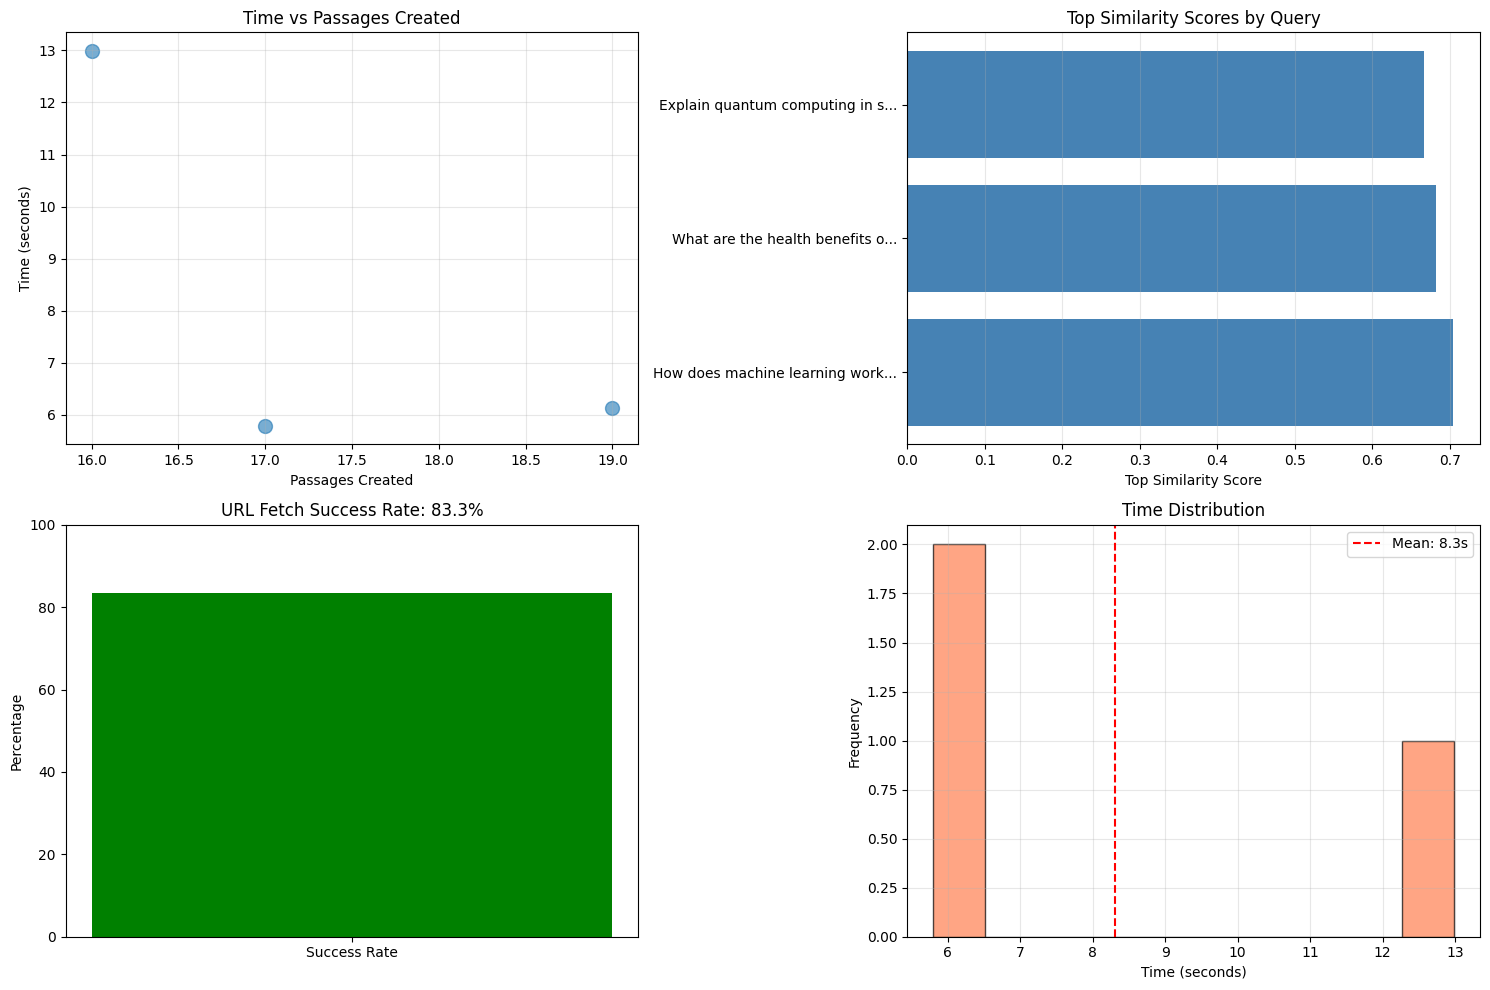


📈 Key Metrics:
   Average time per query: 8.30s
   Average passages created: 17.3
   Average top score: 0.684
   URL fetch success rate: 83.3%


In [47]:
# Analyze performance metrics
if all_results:
    # Create a DataFrame for analysis
    data = []
    for r in all_results:
        if r['passages']:
            data.append({
                'Query': r['query'][:40] + "..." if len(r['query']) > 40 else r['query'],
                'Time (s)': r['time'],
                'URLs Found': r['stats']['urls_found'],
                'URLs Fetched': r['stats']['urls_fetched'],
                'Passages Created': r['stats']['passages_created'],
                'Top Score': max([p['score'] for p in r['passages']]),
                'Avg Score': np.mean([p['score'] for p in r['passages']]),
                'Summary Length': len(r['summary'])
            })
    
    if data:
        df = pd.DataFrame(data)
        print("\n📊 Performance Summary:")
        print("="*70)
        print(df.to_string(index=False))
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time vs Passages
        axes[0, 0].scatter(df['Passages Created'], df['Time (s)'], s=100, alpha=0.6)
        axes[0, 0].set_xlabel('Passages Created')
        axes[0, 0].set_ylabel('Time (seconds)')
        axes[0, 0].set_title('Time vs Passages Created')
        axes[0, 0].grid(alpha=0.3)
        
        # Top Scores
        axes[0, 1].barh(range(len(df)), df['Top Score'], color='steelblue')
        axes[0, 1].set_yticks(range(len(df)))
        axes[0, 1].set_yticklabels([q[:30] + "..." if len(q) > 30 else q for q in df['Query']])
        axes[0, 1].set_xlabel('Top Similarity Score')
        axes[0, 1].set_title('Top Similarity Scores by Query')
        axes[0, 1].grid(axis='x', alpha=0.3)
        
        # Success Rate
        success_rate = (df['URLs Fetched'] / df['URLs Found'] * 100).mean()
        axes[1, 0].bar(['Success Rate'], [success_rate], color='green' if success_rate > 50 else 'orange')
        axes[1, 0].set_ylabel('Percentage')
        axes[1, 0].set_title(f'URL Fetch Success Rate: {success_rate:.1f}%')
        axes[1, 0].set_ylim(0, 100)
        
        # Time Distribution
        axes[1, 1].hist(df['Time (s)'], bins=10, color='coral', edgecolor='black', alpha=0.7)
        axes[1, 1].set_xlabel('Time (seconds)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Time Distribution')
        axes[1, 1].axvline(df['Time (s)'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["Time (s)"].mean():.1f}s')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n📈 Key Metrics:")
        print(f"   Average time per query: {df['Time (s)'].mean():.2f}s")
        print(f"   Average passages created: {df['Passages Created'].mean():.1f}")
        print(f"   Average top score: {df['Top Score'].mean():.3f}")
        print(f"   URL fetch success rate: {success_rate:.1f}%")


## Step 14: Hands-On Exercises

Now it's your turn! Try these exercises to deepen your understanding.

### Exercise 1: Modify Chunk Size

**Task**: Experiment with different chunk sizes and see how it affects results.

**Questions to answer**:
- What happens with very small chunks (20 words)?
- What happens with very large chunks (300 words)?
- What's the optimal chunk size for your use case?


In [48]:
# EXERCISE 1: Test different chunk sizes
# TODO: Modify the chunk_passages function to test different sizes
# Compare results and similarity scores

def test_chunk_sizes(query: str, chunk_sizes: List[int]):
    """
    Test different chunk sizes and compare results.
    
    TODO: Implement this function to:
    1. Run the agent with different chunk sizes
    2. Compare similarity scores
    3. Compare summary quality
    4. Visualize the differences
    """
    # Your code here
    pass

# Uncomment and complete:
# test_chunk_sizes("What is machine learning?", [50, 120, 200, 300])
print("📝 Exercise 1: Implement test_chunk_sizes() function above!")


📝 Exercise 1: Implement test_chunk_sizes() function above!


### Exercise 2: Add Filtering by Score Threshold

**Task**: Modify the agent to only include passages above a certain similarity threshold.

**Implementation**: Add a `min_score` parameter that filters out low-scoring passages.


In [49]:
# EXERCISE 2: Add score threshold filtering
# TODO: Modify the ShortResearchAgent.run() method to filter by minimum score

def run_with_threshold(self, query: str, min_score: float = 0.3, verbose: bool = True):
    """
    Run research with a minimum similarity score threshold.
    
    Only passages with similarity >= min_score will be included.
    
    TODO: Implement this method by modifying the existing run() method
    """
    # Your code here
    # Hint: Filter top_passages by score before creating summary
    pass

print("📝 Exercise 2: Add score threshold filtering to the agent!")


📝 Exercise 2: Add score threshold filtering to the agent!


### Exercise 3: Implement Source Diversity

**Task**: Ensure the summary includes passages from multiple different sources (URLs).

**Challenge**: Modify the summarization logic to prioritize diversity of sources.


In [50]:
# EXERCISE 3: Implement source diversity
# TODO: Modify the summary generation to ensure multiple sources

def summarize_with_diversity(passages: List[Dict], query_embedding: np.ndarray, 
                            num_sentences: int, embedder):
    """
    Generate summary ensuring sentences come from different sources.
    
    TODO: Implement this function to:
    1. Group sentences by source URL
    2. Select top sentences from each source
    3. Ensure diversity in the final summary
    """
    # Your code here
    pass

print("📝 Exercise 3: Implement source diversity in summarization!")


📝 Exercise 3: Implement source diversity in summarization!


### Exercise 4: Add Caching

**Task**: Implement caching to avoid re-fetching the same URLs.

**Implementation**: Cache fetched content and embeddings to speed up repeated queries.


In [51]:
# EXERCISE 4: Add caching
# TODO: Implement a caching system

from functools import lru_cache
import hashlib

class CachedResearchAgent(ShortResearchAgent):
    """
    Research agent with caching to avoid re-fetching URLs.
    
    TODO: Implement caching for:
    1. Fetched page content (by URL)
    2. Embeddings (by text content)
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._url_cache = {}  # Cache for URL content
        self._embedding_cache = {}  # Cache for embeddings
    
    def fetch_text_cached(self, url: str) -> str:
        """
        Fetch text with caching.
        
        TODO: Check cache first, only fetch if not cached
        """
        # Your code here
        pass
    
    def get_embedding_cached(self, text: str) -> np.ndarray:
        """
        Get embedding with caching.
        
        TODO: Use hash of text as cache key
        """
        # Your code here
        pass

print("📝 Exercise 4: Implement caching to speed up repeated queries!")


📝 Exercise 4: Implement caching to speed up repeated queries!


## Step 15: Troubleshooting and Common Issues

### Issue 1: No Results Found

**Symptoms**: Agent returns empty passages or "No documents fetched"

**Solutions**:
1. Check internet connection
2. Try a different search query
3. Increase `SEARCH_RESULTS` to search more pages
4. Check if DuckDuckGo is accessible
5. Increase `TIMEOUT` if pages are slow to load


In [52]:
# Debug helper function
def debug_search(query: str):
    """Debug search and fetch process."""
    print(f"Debugging query: '{query}'\n")
    
    # Test search
    print("1. Testing web search...")
    urls = search_web(query, max_results=3)
    print(f"   Found {len(urls)} URLs")
    for i, url in enumerate(urls, 1):
        print(f"   {i}. {url}")
    
    if not urls:
        print("   ❌ No URLs found. Check internet connection or try different query.")
        return
    
    # Test fetching
    print("\n2. Testing page fetching...")
    for i, url in enumerate(urls[:2], 1):
        print(f"\n   Testing URL {i}: {url[:60]}...")
        text = fetch_text(url)
        if text:
            print(f"   ✅ Successfully fetched {len(text)} characters")
            print(f"   Preview: {text[:100]}...")
        else:
            print(f"   ❌ Failed to fetch content")
    
    print("\n💡 If fetching fails, the page might:")
    print("   - Require JavaScript (we can't handle that)")
    print("   - Be behind a paywall")
    print("   - Have non-standard HTML structure")
    print("   - Be too slow (increase TIMEOUT)")


# Uncomment to debug:
# debug_search("Python programming")
print("💡 Use debug_search() to troubleshoot issues!")


💡 Use debug_search() to troubleshoot issues!


### Issue 2: Low Similarity Scores

**Symptoms**: All similarity scores are very low (< 0.3)

**Solutions**:
1. Try a more specific query
2. Use a different embedding model (larger models often perform better)
3. Increase chunk size (larger context might help)
4. Check if the search results are actually relevant


### Issue 3: Slow Performance

**Symptoms**: Agent takes a very long time to complete

**Solutions**:
1. Reduce `SEARCH_RESULTS` (fewer pages to fetch)
2. Reduce `PASSAGES_PER_PAGE` (less content to process)
3. Use a smaller embedding model (faster but lower quality)
4. Reduce `TOP_PASSAGES` and `SUMMARY_SENTENCES`
5. Implement caching (see Exercise 4)


## Step 16: Advanced Topics and Extensions

### Topic 1: Alternative Similarity Metrics

Cosine similarity is just one way to measure similarity. Other options include:
- **Euclidean Distance**: Straight-line distance between vectors
- **Dot Product**: Simple multiplication (faster but less normalized)
- **Manhattan Distance**: Sum of absolute differences


In [53]:
# Alternative similarity metrics
def euclidean_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Euclidean distance (lower = more similar)."""
    return -np.linalg.norm(a - b)  # Negative because lower distance = higher similarity

def dot_product_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Dot product (faster but not normalized)."""
    return np.dot(a, b)

def manhattan_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Manhattan distance (lower = more similar)."""
    return -np.sum(np.abs(a - b))

# Compare different metrics
test_texts = [
    "Machine learning is a subset of artificial intelligence",
    "AI includes machine learning and deep learning",
    "The weather is sunny today"
]

embeddings = agent.embedder.encode(test_texts, convert_to_numpy=True)
query_emb = embeddings[0]

print("Comparing similarity metrics:\n")
for i, text in enumerate(test_texts[1:], 1):
    emb = embeddings[i]
    cos_sim = agent.cosine_similarity(query_emb, emb)
    euc_sim = euclidean_similarity(query_emb, emb)
    dot_sim = dot_product_similarity(query_emb, emb)
    man_sim = manhattan_similarity(query_emb, emb)
    
    print(f"Text {i}: {text[:50]}...")
    print(f"  Cosine:      {cos_sim:.4f}")
    print(f"  Euclidean:   {euc_sim:.4f}")
    print(f"  Dot Product: {dot_sim:.4f}")
    print(f"  Manhattan:   {man_sim:.4f}\n")

print("💡 Cosine similarity is most commonly used because it's:")
print("   - Normalized (always between -1 and 1)")
print("   - Scale-invariant (works regardless of vector magnitude)")
print("   - Good for high-dimensional spaces")


Comparing similarity metrics:

Text 1: AI includes machine learning and deep learning...
  Cosine:      0.6989
  Euclidean:   -0.7760
  Dot Product: 0.6989
  Manhattan:   -12.1156

Text 2: The weather is sunny today...
  Cosine:      -0.0085
  Euclidean:   -1.4202
  Dot Product: -0.0085
  Manhattan:   -21.9566

💡 Cosine similarity is most commonly used because it's:
   - Normalized (always between -1 and 1)
   - Scale-invariant (works regardless of vector magnitude)
   - Good for high-dimensional spaces


### Topic 2: Better Chunking Strategies

The current chunking is simple word-based. Better strategies include:
- **Sentence-aware chunking**: Don't split in the middle of sentences
- **Overlapping chunks**: Include some overlap to avoid losing context
- **Semantic chunking**: Use embeddings to find natural break points


In [54]:
def chunk_passages_sentence_aware(text: str, max_words: int = 120) -> List[str]:
    """
    Chunk text while respecting sentence boundaries.
    
    This is better than simple word-based chunking because it:
    - Doesn't split sentences in half
    - Preserves meaning better
    - Creates more natural chunks
    """
    sentences = split_sentences(text)
    chunks = []
    current_chunk = []
    current_word_count = 0
    
    for sentence in sentences:
        word_count = len(sentence.split())
        if current_word_count + word_count <= max_words:
            current_chunk.append(sentence)
            current_word_count += word_count
        else:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_word_count = word_count
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks


def chunk_passages_overlapping(text: str, max_words: int = 120, overlap: int = 20) -> List[str]:
    """
    Create overlapping chunks to preserve context.
    
    Overlap helps ensure important information at boundaries isn't lost.
    """
    words = text.split()
    if not words:
        return []
    
    chunks = []
    i = 0
    while i < len(words):
        chunk = words[i : i + max_words]
        chunks.append(" ".join(chunk))
        i += max_words - overlap  # Move forward but keep overlap
    
    return chunks


# Compare chunking strategies
test_text = """
Artificial intelligence is transforming industries. Machine learning algorithms can process vast amounts of data. 
Deep learning uses neural networks inspired by the human brain. Natural language processing enables computers to understand text.
Computer vision allows machines to interpret images. These technologies are revolutionizing healthcare, finance, and transportation.
""" * 5

print("Comparing chunking strategies:\n")
print(f"Original text: {len(test_text.split())} words\n")

# Simple chunking
simple_chunks = chunk_passages(test_text, max_words=50)
print(f"Simple chunking: {len(simple_chunks)} chunks")
print(f"  First chunk: {simple_chunks[0][:80]}...\n")

# Sentence-aware chunking
sentence_chunks = chunk_passages_sentence_aware(test_text, max_words=50)
print(f"Sentence-aware chunking: {len(sentence_chunks)} chunks")
print(f"  First chunk: {sentence_chunks[0][:80]}...\n")

# Overlapping chunking
overlap_chunks = chunk_passages_overlapping(test_text, max_words=50, overlap=10)
print(f"Overlapping chunking: {len(overlap_chunks)} chunks")
print(f"  First chunk: {overlap_chunks[0][:80]}...")
print(f"  Second chunk: {overlap_chunks[1][:80]}... (notice the overlap)")


Comparing chunking strategies:

Original text: 235 words

Simple chunking: 5 chunks
  First chunk: Artificial intelligence is transforming industries. Machine learning algorithms ...

Sentence-aware chunking: 5 chunks
  First chunk: Artificial intelligence is transforming industries. Machine learning algorithms ...

Overlapping chunking: 6 chunks
  First chunk: Artificial intelligence is transforming industries. Machine learning algorithms ...
  Second chunk: technologies are revolutionizing healthcare, finance, and transportation. Artifi... (notice the overlap)


## Step 17: Real-World Applications

### Application 1: Academic Research Assistant

Use the agent to quickly gather information for papers and research.


In [55]:
# Example: Academic research query
academic_query = "What are the latest developments in transformer neural networks?"

print("🔬 Academic Research Example:")
print("="*70)
academic_result = agent.run(academic_query, verbose=False)
display_results(academic_result)


🔬 Academic Research Example:

📊 RESEARCH RESULTS

🔍 Query: What are the latest developments in transformer neural networks?

📈 Statistics:
   URLs found: 6
   URLs successfully fetched: 4
   Passages created: 16
   Top passages selected: 5
   Time taken: 3.90 seconds

🏆 Top Relevant Passages:
----------------------------------------------------------------------

1. Score: 0.643
   Source: https://www.ibm.com/think/topics/transformer-model
   Passage: Staff Editor, AI Models IBM Think Senior Staff Writer, AI Models IBM Think The transformer model is a type of neural network architecture that excels at processing sequential data, most prominently associated with large language models (LLMs) . Transformer models have also achieved elite performance...

2. Score: 0.610
   Source: https://en.wikipedia.org/wiki/Transformer_(deep_learning)
   Passage: In deep learning , the transformer is an artificial neural network architecture based on the multi-head attention mechanism, in which text is 

### Application 2: Competitive Intelligence

Research competitors and market trends.


In [56]:
# Example: Market research query
market_query = "What are the trends in electric vehicle adoption in 2024?"

print("📊 Market Research Example:")
print("="*70)
market_result = agent.run(market_query, verbose=False)
display_results(market_result)


📊 Market Research Example:

📊 RESEARCH RESULTS

🔍 Query: What are the trends in electric vehicle adoption in 2024?

📈 Statistics:
   URLs found: 6
   URLs successfully fetched: 6
   Passages created: 24
   Top passages selected: 5
   Time taken: 6.47 seconds

🏆 Top Relevant Passages:
----------------------------------------------------------------------

1. Score: 0.763
   Source: https://about.bnef.com/insights/clean-transport/electric-vehicle-outlook/
   Passage: the world and covers all major vehicle markets. It includes analysis on vehicle sales, oil markets, electricity demand, charging infrastructure, batteries, metals and CO2 emissions. Download Executive Summary Global sales of electric vehicles continue to rise and are set to represent one in four car...

2. Score: 0.694
   Source: https://www.recurrentauto.com/research/ev-adoption-us
   Passage: Recurrent an early look at their estimate in April 2024 ahead of several large industry shifts, including revised EPA targets and up

## Step 18: Summary and Key Takeaways

### What You've Learned

1. **Vector Embeddings**: Text → Numbers that capture meaning
2. **Semantic Search**: Finding meaning, not just keywords
3. **RAG Architecture**: Retrieve → Rank → Generate
4. **Cosine Similarity**: Measuring semantic similarity
5. **Text Chunking**: Breaking documents into manageable pieces

### The Complete Pipeline

```
Query → Search Web → Fetch Pages → Chunk Text → Create Embeddings 
→ Calculate Similarity → Rank Passages → Generate Summary
```

### Key Concepts Recap

- **Embeddings vs Vectors**: Embeddings are vectors that represent meaning
- **Chunking**: Smaller pieces = more precise matching
- **Similarity**: Higher score = more relevant to your query
- **RAG**: The architecture powering many modern AI systems

### Next Steps

1. ✅ Complete the exercises to deepen your understanding
2. ✅ Experiment with different parameters and models
3. ✅ Try the advanced features and extensions
4. ✅ Build your own customizations
5. ✅ Apply this to your own research needs

### Further Learning

- Explore other embedding models (OpenAI, Cohere, etc.)
- Learn about more advanced RAG techniques
- Study transformer architectures
- Experiment with different similarity metrics
- Build a web interface for your agent

---

## 🎉 Congratulations!

You've built a complete AI research agent from scratch! This is the foundation of many powerful AI systems used in production today.

**Remember**: The journey from a simple script to a powerful AI system is just a series of small, understandable steps. You've taken the first and most important one!

---

## 📝 Final Exercise: Build Your Own Feature

**Challenge**: Add a feature of your own design. Some ideas:
- Multi-language support
- PDF document processing
- Citation formatting
- Real-time updates
- Integration with databases
- Web interface

**Share your creation and what you learned!**


In [57]:
# Final exercise: Your custom feature here!
# TODO: Implement your own feature

def my_custom_feature():
    """
    Your custom feature implementation.
    
    Ideas:
    - Add support for multiple languages
    - Process PDF documents
    - Format citations in different styles
    - Add real-time web updates
    - Integrate with a database
    - Create a web interface
    """
    pass

print("🚀 Build something amazing!")
print("   The best way to learn is by building!")


🚀 Build something amazing!
   The best way to learn is by building!
